#**CIS 5450 Final Project: Stock Price Predictor**
*Group 74: Arya Bansal and Mona Khosla*

# Part 1: Introduction and Background Information
**Problem Statement:**

Stock price prediction is a hot topic, and the ability to do so can help a company or individual profit greatly. Stock price movements are influenced by many factors, ranging from macroeconomic trends to Industry trends. Thus for our final project, we have decided to source data on stock prices and interest rates to build a model that can predict a stock's price.

Interest rates are often considered a critical driver of market behavior, yet their influence on stock prices is uncertain. In this project, we aim to investigate this relationship and other technical indicators to predict stock prices.

**Objective:**

**1. Predictive Modeling:** Develop a robust machine learning model to predict stock prices using past stock features and interest rates.

**2. Feature Importance Analysis:** Determine which features are most correlated with a stock's closing price.



**Overview of Datasets:**

To achieve our objectives, we utilized two primary datasets sourced from Kaggle:

**1. Stock Prices Dataset (`stocks_df`):**

- Contains daily open, close, high, and low prices, along with trading volume data for 505 different stocks.

- Focused analysis on the top 50 stocks by average trading volume to ensure data relevance and manageability.

- Covers the period from 2013 to 2018, encompassing over 50,000 rows of data.



**2. Interest Rates Dataset (`rates_df`):**

- Provides daily interest rate data spanning from 1954 to 2024.

- Filtered to match the date range of `stocks_df` for alignment in analysis.

- Offers a critical macroeconomic perspective by introducing an additional feature into our predictive model.

- Data Preprocessing and Feature Engineering:

After merging `stocks_df` and `rates_df` into a unified dataset (`merged_df`), we conducted extensive preprocessing and feature engineering to prepare the data for analysis. Key transformations included:

- Handling missing values and aligning temporal data.

- Creating additional financial features (e.g., daily returns, moving averages, and volatility metrics).

- Normalizing and scaling data to ensure compatibility with machine learning models.

**Exploratory Data Analysis (EDA) Highlights:**

EDA revealed insightful trends and relationships within the data:



- Stock Behavior Analysis: Identified patterns in stock price movements and trading volumes, highlighting the variability across different stocks.

- Interest Rate Trends: Examined fluctuations in interest rates over time and their potential correlation with stock market activity.

- Correlation Analysis: Explored the relationships between stock prices, trading volumes, and interest rates to identify key predictive features.

**Model Development and Insights:**

Using the cleaned and engineered dataset, we trained various predictive models to forecast stock prices. The integration of interest rates allowed us to assess their impact on prediction accuracy and their relative importance among other features.



This comprehensive approach not only improves predictive performance but also provides actionable insights into the interplay between stock prices and macroeconomic factors, offering a valuable tool for stakeholders navigating the complexities of financial markets.

## Part 1.1: Importing Libraries

In [ ]:
# Import libraries
!pip install ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import kagglehub
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA

# Part 2: Data Pre-Processing and EDA on `stocks_df`

In this part we performed EDA on a dataset of stock prices which we derived from Kaggle. Our analysis is composed of determining the descriptive statistics, cleaning the data for our use, and creating different visuals to analyze certain features.

## Part 2.1: Importing the dataset from Kaggle and gathering preliminary descriptive statistics

In [ ]:
# Download latest version
path = kagglehub.dataset_download("rohitjain454/all-stocks-5yr")
print("Path to dataset files:", path)

# Load dataset
data_path = '/root/.cache/kagglehub/datasets/rohitjain454/all-stocks-5yr/versions/1/all_stocks_5yr.csv'
stocks_df = pd.read_csv(data_path)
print(stocks_df.head())

# Convert date to datetime
stocks_df['date'] = pd.to_datetime(stocks_df['date'])

# Drop rows with missing values
stocks_df.dropna(inplace=True)

# Sort by stock name and date
stocks_df.sort_values(by=['Name', 'date'], inplace=True)

# Count the number of rows
rows = len(stocks_df)
print(f"Number of rows in the dataset: {rows}")

# Count the number of unique stocks there are
print(f"Number of unique stocks in the dataset: {stocks_df['Name'].nunique()}")


Path to dataset files: /root/.cache/kagglehub/datasets/rohitjain454/all-stocks-5yr/versions/1
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
Number of rows in the dataset: 619029
Number of unique stocks in the dataset: 505


In [ ]:
# Determine the date range for the dataset
date_range = (stocks_df['date'].min(), stocks_df['date'].max())
print(f"Date range: {date_range[0]} to {date_range[1]}")

Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00


## Part 2.2: Determining the top 50 stocks
For this project we only wish to include the top 50 stocks by average trading volume in our analysis. The following code details how we obtain `filtered_stocks_df`.  

In [ ]:
# Calculate the average trading volume per stock
average_volume_per_stock = stocks_df.groupby('Name')['volume'].mean().sort_values(ascending=False)

# Get the top 50 stocks with the highest average trading volume
top_stocks = average_volume_per_stock.head(50).index

# Filter the original dataset to include only the top 50 stocks
filtered_stocks_df = stocks_df[stocks_df['Name'].isin(top_stocks)]

# Check the number of rows and unique stock names in the filtered data
print(f"Number of rows in filtered data: {filtered_stocks_df.shape[0]}")
print(f"Number of unique stocks in filtered data: {filtered_stocks_df['Name'].nunique()}")

Number of rows in filtered data: 60898
Number of unique stocks in filtered data: 50


## Part 2.3: EDA and analysis with `filtered_stocks_df`

### Part 2.3.1: Close Price Analysis
The close price is a key metric that reflects a stock's final trading value for the day, offering insights into market sentiment and historical trends. Here, we analyze average close prices across stocks and explore how they vary over time to uncover key patterns.

**Methodology:**

- **Calculate Average Close Prices:** Assess the mean close price for each stock over 2013–2018, highlighting top performers and low-value equities.

- **Temporal Analysis:** Examine trends in close prices over time, identifying growth, stability, or decline.

- **Visualization:** Use charts to display close price distributions, time-series trends, and volatility.

**Insights:**

- **Stock Performance:** Identify consistently high- or low-performing stocks.

- **Market Trends:** Highlight periods of market shifts, such as bullish or bearish trends.

- **Volatility Patterns:** Spot the most stable and volatile equities.
This analysis lays the foundation for understanding stock behavior and its relationship with features like trading volume and interest rates.

In [ ]:
#Determine the average close price for each stock
ticker_grouped = filtered_stocks_df.groupby('Name').agg({'close': 'mean'})
ticker_grouped.sort_values(by='close', ascending=False)
ticker_grouped.head(10)

,close
Name,
AAL,38.393252
AAPL,109.066698
AMAT,25.838925
AMD,5.601863
BAC,17.704178
BSX,17.903892
C,53.467951
CHK,13.681326
CMCSA,30.003741


The following plots depict the close price for each ticker in `filtered_stocks_df`. Since we are working with several stocks, a **bar diagram** can help us easily compare average prices as it clearly depicts the average close price for each stock.


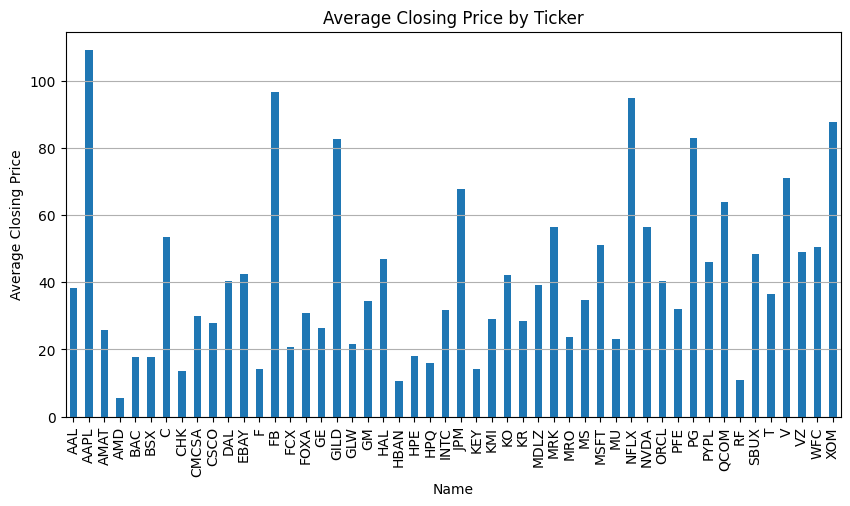

In [ ]:
# plots a bar diagram for visualizing the average closing price for each of the 50 selected stocks
ticker_grouped['close'].plot(kind='bar', figsize=(10, 5), title='Average Closing Price by Ticker')
plt.ylabel('Average Closing Price')
plt.grid(axis='y')
plt.show()

**Key Takeaway:** From this visual it is clear that the Apple stock (AAPL) has had the highest average closing price.

Thus to perform a deeper dive into the Apple stock, we created a time-series line chart to analyze how close price varies over time.

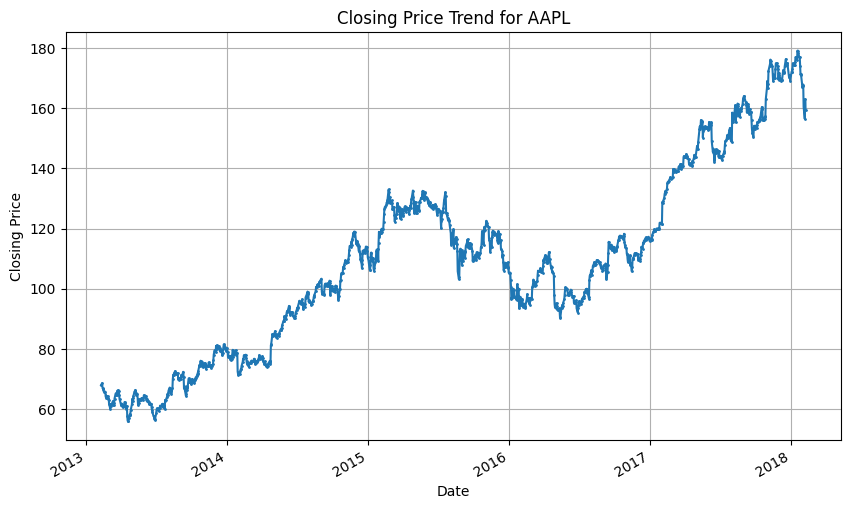

In [ ]:
# Analyzes the close price over time for one particular stock
plt.figure(figsize=(10, 6))
filtered_stocks_df[filtered_stocks_df['Name'] == 'AAPL'].plot(x='date', y='close', marker='o', markersize = 1, title='Closing Price Trend for AAPL', legend=False, ax=plt.gca())
plt.ylabel('Closing Price')
plt.xlabel('Date')
plt.grid(True)
plt.show()

**Key Takeaway:** **We can see through this diagram that the close price varies greatly over time.** We hope that through our models later on we can determine what features have the greatest influence on this change and causes this volatility.

The figure below is similar to the one above, but instead plots how the close price varies over time for all stocks in `filtered_stocks_df`.

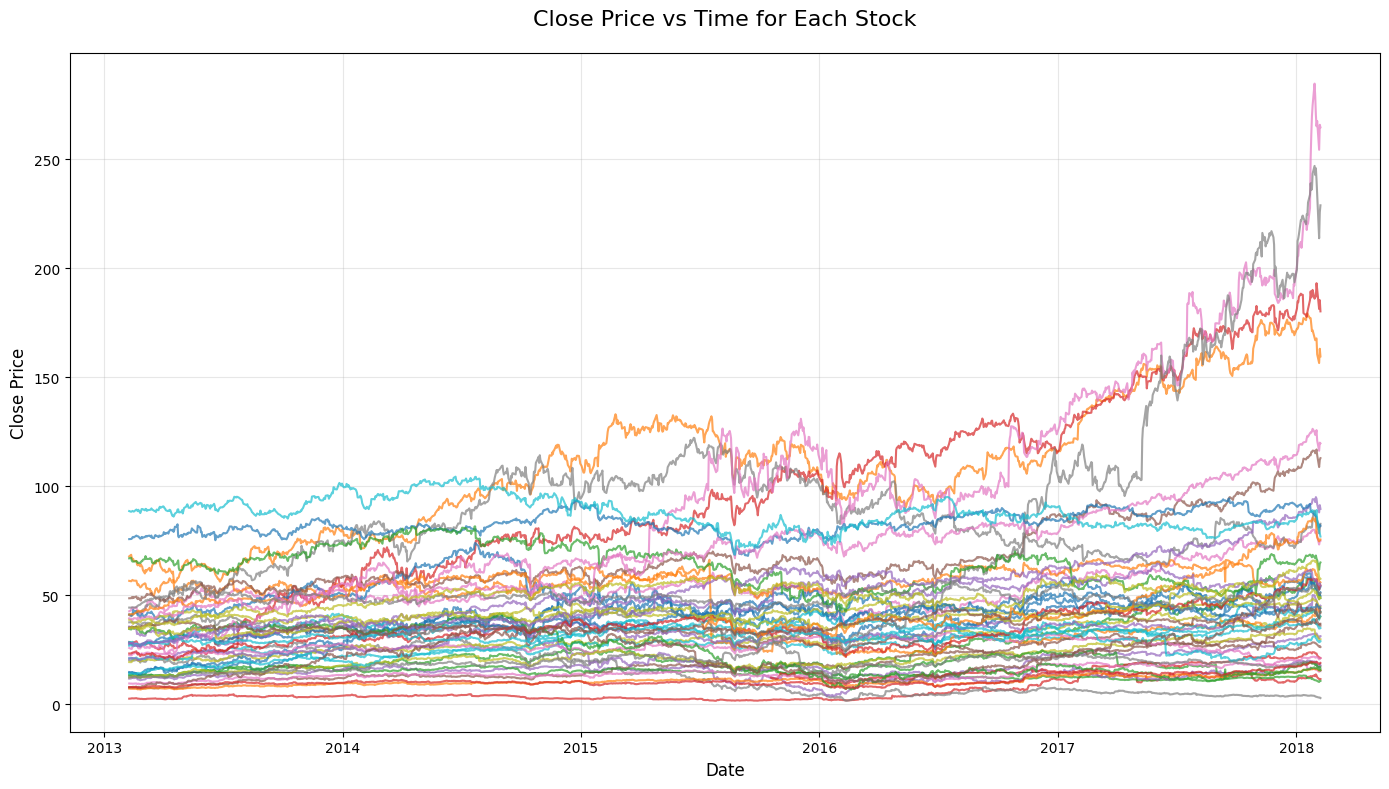

In [ ]:
# Analyzes the stock growth over time for all stocks (close price vs time for each stock)
plt.figure(figsize=(14, 8))

# Loop through each stock name and plot its close price
for name in filtered_stocks_df['Name'].unique():
    stock_data = filtered_stocks_df[filtered_stocks_df['Name'] == name]
    plt.plot(stock_data['date'], stock_data['close'], label=name, alpha=0.7)

# Add title and labels
plt.title("Close Price vs Time for Each Stock", fontsize=16, pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)

# Add grid and adjust layout
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Key Takeaway:** From this diagram we can see that the stocks do not vary in the same way over time. Thus this motivated us to ensure we separated our training and testing data based on stocks in our modelling part.

# Part 3: Data Pre-Processing and EDA on `rates_df`

In this first part we performed EDA on a dataset of interest rates which we derived from Kaggle. Our analysis is composed of determining the descriptive statistics, cleaning the data for our use, and creating different visuals to analyze certain features.

## Part 3.1: Importing the dataset from Kaggle and gathering preliminary descriptive statistics

In [ ]:
!pip install kaggle
from google.colab import drive

# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d natashk/effective-federal-funds-rate

['Dataset URL: https://www.kaggle.com/datasets/natashk/effective-federal-funds-rate',
 'License(s): CC0-1.0',
 'effective-federal-funds-rate.zip: Skipping, found more recently modified local copy (use --force to force download)']

In [ ]:
# Unzip folder in Colab content folder
!unzip  -o /content/effective-federal-funds-rate.zip

Archive:  /content/effective-federal-funds-rate.zip
  inflating: FRB_H15.csv             


In [ ]:
# Define the dataset and destination path
dataset_name = "natashk/effective-federal-funds-rate"

In [ ]:
import pandas as pd
rates_df = pd.read_csv("FRB_H15.csv")

In [ ]:
print(rates_df.head())

  Time Period  RIFSPFF_N.D
0  2024-12-05         4.58
1  2024-12-04         4.58
2  2024-12-03         4.58
3  2024-12-02         4.58
4  2024-12-01         4.58


The following code blocks work with cleaning the data and gather descriptive statistics.

In [ ]:
# Convert date to datetime
rates_df.rename(columns={'Time Period': 'date'}, inplace=True)
rates_df['date'] = pd.to_datetime(rates_df['date'])

# Drop rows with missing values
rates_df.dropna(inplace=True)

# Rename column for rates
rates_df.rename(columns={'RIFSPFF_N.D': 'interest_rates'}, inplace=True)
rates_df['interest_rates'] = rates_df['interest_rates'].astype(float)

# Sort by date
rates_df.sort_values(by=['date'], inplace=True)

# Count the number of rows
rows = len(rates_df)
print(f"Number of rows in the dataset: {rows}")

Number of rows in the dataset: 25726


In [ ]:
# Determine the date range for the dataset
date_range = (rates_df['date'].min(), rates_df['date'].max())
print(f"Date range: {date_range[0]} to {date_range[1]}")

Date range: 1954-07-01 00:00:00 to 2024-12-05 00:00:00


## Part 3.2: Filtering the date range for `rates_df`

For this part, we want to filter the date range of `rates_df` so that the dates match that of `stocks_df`. We will store our filtered dataframe in `filtered_rates_df`.

In [ ]:
# filter the rates dataframe to only consist of the dates available in the stocks dataset
start_date = '2013-02-08'
end_date = '2018-02-07'
filtered_rates_df = rates_df[(rates_df['date'] >= start_date) & (rates_df['date'] <= end_date)]

## Part 3.3: EDA and analysis with `filtered_rates_df`



### Part 3.3.1: Determining the percent change in interest rates
Determining the percent change in interest rates When beginning to work with the interest rates data, we had a lot of questions on when interest rates change and how often do they increase/decrease. In this part we developed visuals and analyses on the interest rate per each month in the five-year period and how it changed from month to month.

**Methodology:**

- **Aggregate Data:** Calculate the average interest rate for each month within the five-year timeframe.

- **Percent Change Calculation:** Determine the percentage change in interest rates from month to month.

- **Visualization:** Develop line charts and bar plots to highlight periods of significant rate hikes or cuts.

**Insights:**

- **Rate Change Patterns:** Visuals reveal how often rates were adjusted and whether trends (e.g., sustained hikes or cuts) emerged.

- **Economic Context:** Periods of large rate changes may correspond to significant economic events, providing valuable context for interpreting stock market reactions.

This analysis forms the foundation for exploring correlations between interest rate fluctuations and stock price behavior.

In the below code, we determined the percent change in interest rate from month to month, as that is the typical time period in which the rate changes. We then labeled each change in a new data frame with the `Increase`, `Decrease`, or `Stable` to help with later visualizations.

In [ ]:
# Extract a month and year column in an intermediate dataframe
inter_df = filtered_rates_df.copy()
inter_df['year'] = inter_df['date'].dt.year
inter_df['month'] = inter_df['date'].dt.month

# Group by year and month
grouped = inter_df.groupby(['year', 'month'])['interest_rates'].mean().reset_index()

# Find percent change between each month and label the change
grouped['rate_change_pct'] = grouped['interest_rates'].pct_change() * 100
grouped['rate_trend'] = np.where(grouped['rate_change_pct'] > 0, 'Increase',
                                np.where(grouped['rate_change_pct'] < 0, 'Decrease', 'Stable'))

# Count occurrences of each rate trend
trend_counts = grouped['rate_trend'].value_counts()

The **bar diagram** below helps us quickly visualize the above trends to see how often the interest rate increases/decreases. This was added on to our project for better understanding of our rates dataset.

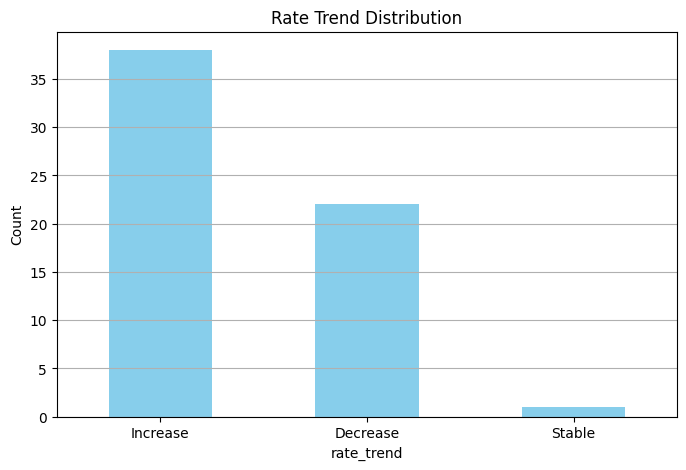

In [ ]:
# Plots a bar diagram of the rate trend distribution
plt.figure(figsize=(8, 5))
trend_counts.plot(kind='bar', color='skyblue')
plt.title('Rate Trend Distribution')
plt.ylabel('Count')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In the following diagram, we can evaluate how the interest rate has changed over time by plotting the percent change from month to month. This analysis helps evaluate the **volatility** in rate changes, highlighting periods of stability, sharp increases, or decreases, which help determine how monetary policy shifts impact broader economic conditions and market behavior.

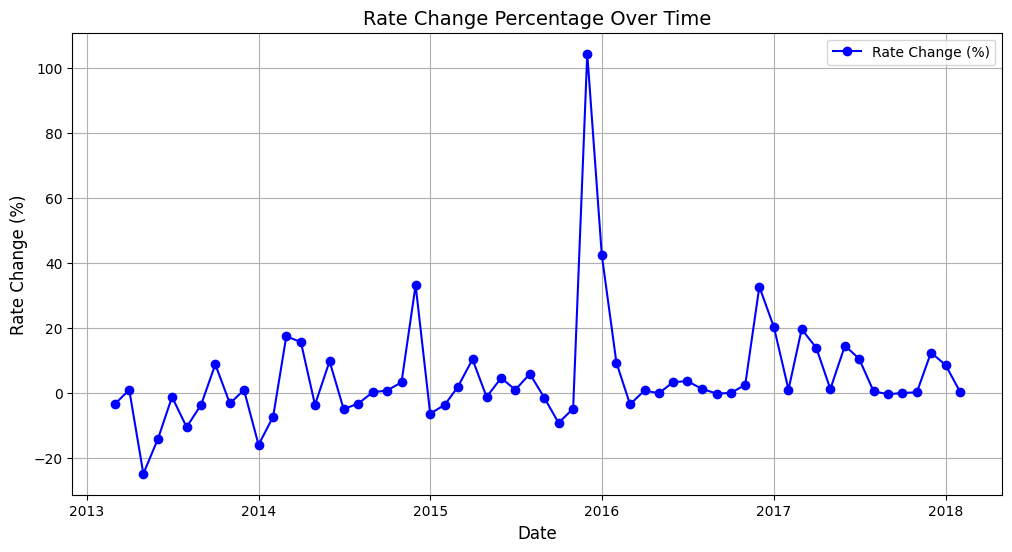

In [ ]:
#Line diagram of Rate Change Percentage Over Time
# Add a date column to grouped for the visual
grouped['date'] = pd.to_datetime(grouped[['year', 'month']].assign(day=1))  # Set day to 1 for uniformity

# Plot the rate_change_pct over time
plt.figure(figsize=(12, 6))
plt.plot(grouped['date'], grouped['rate_change_pct'], marker='o', linestyle='-', label='Rate Change (%)', color='blue')

# Label plot
plt.title('Rate Change Percentage Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate Change (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaway:**


**1. High Volatility Periods:** Significant spikes, such as the large increase in 2015, indicate periods of aggressive rate adjustments, likely tied to major economic or monetary policy events.

**2. Stable Trends:** Extended periods of minimal rate changes (e.g., 2016–2018) reflect market stability or a steady monetary policy approach.

**3. Cyclical Patterns:** The fluctuations suggest a cyclical trend in rate adjustments, with sharp changes followed by periods of stabilization.

# Part 4: Merging Datasets and finalizing EDA
We have now full developed and analyzed the two datasets we will be working with in this project. We will merge the two datasets in order to produce `merged_df` which we will use for feature engineering and training our model.

## Part 4.1: Merge on Date
We merged our two datasets below ensuring that all stock info is still available in `merged_df.`

In [ ]:
merged_df = pd.merge(filtered_stocks_df, filtered_rates_df, on='date', how='left')
merged_df.dropna(inplace=True)
merged_df.head(10)

,date,open,high,low,close,volume,Name,interest_rates
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,0.14
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,0.14
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,0.13
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,0.14
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,0.14
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL,0.16
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL,0.15
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL,0.15
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL,0.16
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL,0.16


## Part 4.2: Plotting the merged data

In this section we plotted the average interest rate (on a logarithmic scale) and stock price over time. From this we can infer a relationship between the two variables.

<Figure size 1000x600 with 0 Axes>

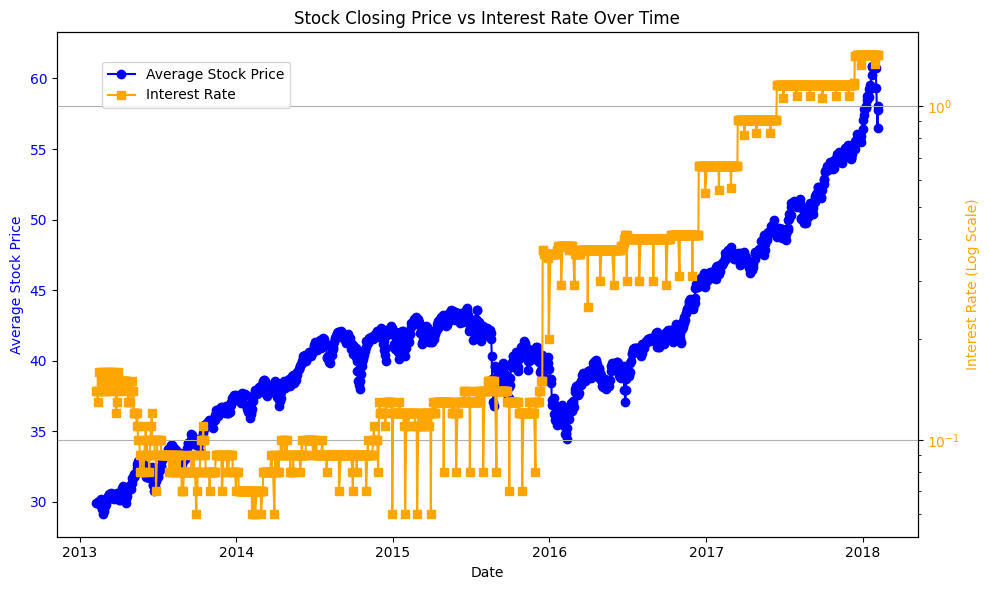

In [ ]:
# Grouped data by 'date' with averages
grouped_data = merged_df.groupby('date').agg({'close': 'mean', 'interest_rates': 'mean'})

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot stock closing prices (linear scale)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(grouped_data.index, grouped_data['close'], marker='o', label='Average Stock Price', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Stock Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Stock Closing Price vs Interest Rate Over Time")

# Create a twin axis for interest rates (log scale)
ax2 = ax1.twinx()
ax2.plot(grouped_data.index, grouped_data['interest_rates'], marker='s', label='Interest Rate', color='orange')
ax2.set_ylabel("Interest Rate (Log Scale)", color='orange')
ax2.set_yscale('log')  # Set logarithmic scale for the y-axis
ax2.tick_params(axis='y', labelcolor='orange')

# Add grid and legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()

**Key Takeaway:**


**1. Inverse Relationship:** Periods of rising interest rates often coincide with slower growth in stock prices. Thus this could Indicate a potential Inverse relationship.

**2. Market Resilience:** Stock prices show consistent long-term growth.

**3. Notable Divergences:** Specific timeframes, such as 2016–2018, show both metrics increasing, suggesting complex dynamics influenced by additional factors like economic growth or fiscal policies.

This graph is slightly messy and hard to read as it uses too many data points from a variet of stocks. We updated this analysis to focus on one stock (Apple) and the yearly change in interest rates below.

<ipython-input-25-223a9eeb0208>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'])
<ipython-input-25-223a9eeb0208>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['date'].dt.year


<Figure size 1000x600 with 0 Axes>

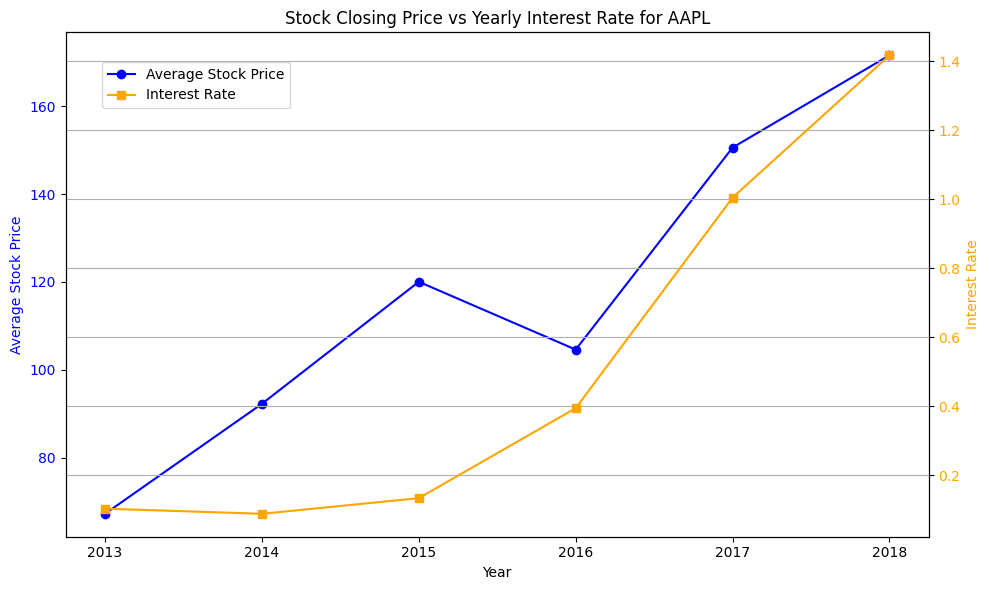

In [ ]:
# Specifies the stock symbol we want to focus on
stock_symbol = 'AAPL'

# Filter the data for the specific stock
filtered_data = merged_df[merged_df['Name'] == stock_symbol]

# Convert 'date' column to datetime format
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Extract year from the 'date' column
filtered_data['year'] = filtered_data['date'].dt.year

# Group filtered data by 'year' and calculate averages
grouped_data = filtered_data.groupby('year').agg({'close': 'mean', 'interest_rates': 'mean'})

# Reset index for plotting
grouped_data = grouped_data.reset_index()

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot stock closing prices (linear scale)
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(grouped_data['year'], grouped_data['close'], marker='o', label='Average Stock Price', color='blue')
ax1.set_xlabel("Year")
ax1.set_ylabel("Average Stock Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f"Stock Closing Price vs Yearly Interest Rate for {stock_symbol}")

# Create a twin axis for interest rates (linear scale)
ax2 = ax1.twinx()
ax2.plot(grouped_data['year'], grouped_data['interest_rates'], marker='s', label='Interest Rate', color='orange')
ax2.set_ylabel("Interest Rate", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add grid and legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()

**Key Takeaway:**

**1. Rate and Price Alignment:** Both stock prices and interest rates exhibit a simultaneous increase after 2016, suggesting a period where higher rates did not dampen investor confidence in AAPL.

**2. Divergence Periods:** In earlier years (2013–2015), stock prices rose significantly while interest rates remained relatively low, potentially reflecting the influence of other factors like market demand and company performance.



# Part 5: Feature Engineering and Preparing Data for Modelling
Currently our dataset is not much help in predicting stock prices, as we have certain categorical variables and very few meaningful values. Thus in this next part we will create additional features and convert our categorical variables to numerical values to aid our models in later parts.

## Part 5.1: Calculating additional features

Feature engineering is critical for enhancing predictive accuracy in stock price modeling. The engineered features in this section provide the model with historical context and additional patterns:

**Lagged Values:** Including lagged features for closing price, open price, and volume allows the model to account for time-dependent trends and autocorrelation in stock prices.

**Rolling Statistics:** Calculating 5-day averages and volatility introduces a sense of short-term market momentum and variability, which are key predictors in financial markets.

**Interaction Terms:** Multiplying interest rates with lagged close prices helps capture the interplay between macroeconomic conditions and stock performance.

**Daily Returns:** Lagged daily returns offer insights into recent performance, allowing the model to consider price direction and strength.
These features collectively enhance the model's ability to recognize temporal patterns and the influence of external factors, leading to better forecasting performance.

In [ ]:
# Calculate derived features
merged_df['lagged_close'] = merged_df['close'].shift(1)

merged_df['lagged_5_day_avg'] = merged_df['close'].shift(1).rolling(window=5).mean()
merged_df['lagged_volatility_5d'] = merged_df['close'].shift(1).rolling(window=5).std()

merged_df['lagged_daily_return'] = (merged_df['lagged_close'] - merged_df['close'].shift(2)) / merged_df['close'].shift(2)
merged_df['interaction_term'] = merged_df['interest_rates'] * merged_df['lagged_close'] # Determine percent change in stock price

merged_df['lagged_open'] = merged_df['open'].shift(1)
merged_df['lagged_high'] = merged_df['high'].shift(1)
merged_df['lagged_low'] = merged_df['low'].shift(1)
merged_df['lagged_volume'] = merged_df['volume'].shift(1)


# Drop rows with NaNs caused by rolling calculations
merged_df.dropna(inplace=True)

The following code adds the relative strength feature to merged_df. The Relative Strength Index (RSI) is a widely used momentum indicator in financial analysis, which can measure the speed and magnitude of recent price changes, helping to identify whether a stock is overbought or oversold. This can indicate potential price reversals or continuations, which are critical for forecasting.

In [ ]:
# Relative Strength Index (RSI)
# RSI Calculation Parameters
rsi_period = 14  # Typical value for RSI

# Calculate price changes
merged_df['price_change'] = merged_df['close'] - merged_df['close'].shift(1)

# Calculate gains and losses
merged_df['gain'] = np.where(merged_df['price_change'] > 0, merged_df['price_change'], 0)
merged_df['loss'] = np.where(merged_df['price_change'] < 0, -merged_df['price_change'], 0)

# Calculate average gain and loss
merged_df['avg_gain'] = merged_df['gain'].rolling(window=rsi_period).mean()
merged_df['avg_loss'] = merged_df['loss'].rolling(window=rsi_period).mean()

# Calculate RS (Relative Strength)
merged_df['rs'] = merged_df['avg_gain'] / merged_df['avg_loss']

# Calculate RSI
merged_df['rsi'] = 100 - (100 / (1 + merged_df['rs']))

merged_df.dropna(inplace=True)
merged_df.head()

,date,open,high,low,close,volume,Name,interest_rates,lagged_close,lagged_5_day_avg,...,lagged_high,lagged_low,lagged_volume,price_change,gain,loss,avg_gain,avg_loss,rs,rsi
18,2013-03-07,14.70,14.93,14.50,14.82,9125300,AAL,0.16,14.57,13.912,...,14.68,14.25,13243200.0,0.25,0.25,0.0,0.145714,0.122857,1.186047,54.255319
19,2013-03-08,14.99,15.20,14.84,14.92,10593700,AAL,0.15,14.82,14.190,...,14.93,14.50,9125300.0,0.10,0.10,0.0,0.152857,0.122857,1.244186,55.440415
20,2013-03-11,14.85,15.15,14.71,15.13,6961800,AAL,0.16,14.92,14.452,...,15.20,14.84,10593700.0,0.21,0.21,0.0,0.167857,0.105714,1.587838,61.357702
21,2013-03-12,15.14,15.60,14.95,15.50,8999100,AAL,0.15,15.13,14.698,...,15.15,14.71,6961800.0,0.37,0.37,0.0,0.194286,0.039286,4.945455,83.180428
22,2013-03-13,15.54,16.20,15.48,15.91,11380000,AAL,0.14,15.50,14.988,...,15.60,14.95,8999100.0,0.41,0.41,0.0,0.220714,0.039286,5.618182,84.890110


## Part 5.2: Addressing if our features are correlated

### Part 5.2.1: Determining a correaltion matrix between our features and close price
A correlation matrix is necessary for understanding the relationships between features and the target variable. It helps identify multicollinearity (high correlation between independent variables), which could lead to unstable models. By performing a correlation matrix, we can reduce noise and find the most impactful features.

In [ ]:
correlation_matrix = merged_df[['close','lagged_open', 'lagged_high', 'lagged_low','lagged_volume', 'lagged_5_day_avg', 'lagged_volatility_5d', 'interest_rates', 'lagged_daily_return', 'interaction_term', 'rsi']].corr()
print(correlation_matrix['close'].sort_values(ascending=False))

close                   1.000000
lagged_low              0.997554
lagged_high             0.997528
lagged_open             0.997427
lagged_5_day_avg        0.994938
interaction_term        0.680977
interest_rates          0.184016
lagged_volatility_5d    0.174574
rsi                     0.089962
lagged_daily_return     0.012449
lagged_volume          -0.101315
Name: close, dtype: float64


**Key Takeaway:** This code block computes a correlation matrix to examine how our engineered features correlate to our target feature of close price.

**Highly Correlated Features:** Lagged features such as `lagged_open, lagged_high, and lagged_low` show a strong positive correlations with close, suggesting a large predictive relevance.

**Moderate Correlations**: Features like the interaction term and interest rates exhibit moderate correlations.

**Low Correlation Features:** Features such as lagged_daily_return and lagged_volume show weaker correlations.

Our variable of interest from the start was interest rates. Here we can see interest rates have a realtively lower correlation to close price.

### Part 5.2.2: Plotting a correlation matrix between the features themselves

The following diagram determines the correlation between each feature. Visualizing the correlation matrix helps to quickly identify relationships and patterns among features. We used a heatmap to depict how correlated the features are.

Note: we use one-hot encoding later to incorporate the stock symbol as a feature, but that is not depicted in this map as we found it was not highly correlated with any features and as it made our feature set too large to be visualized in such a correlation map.

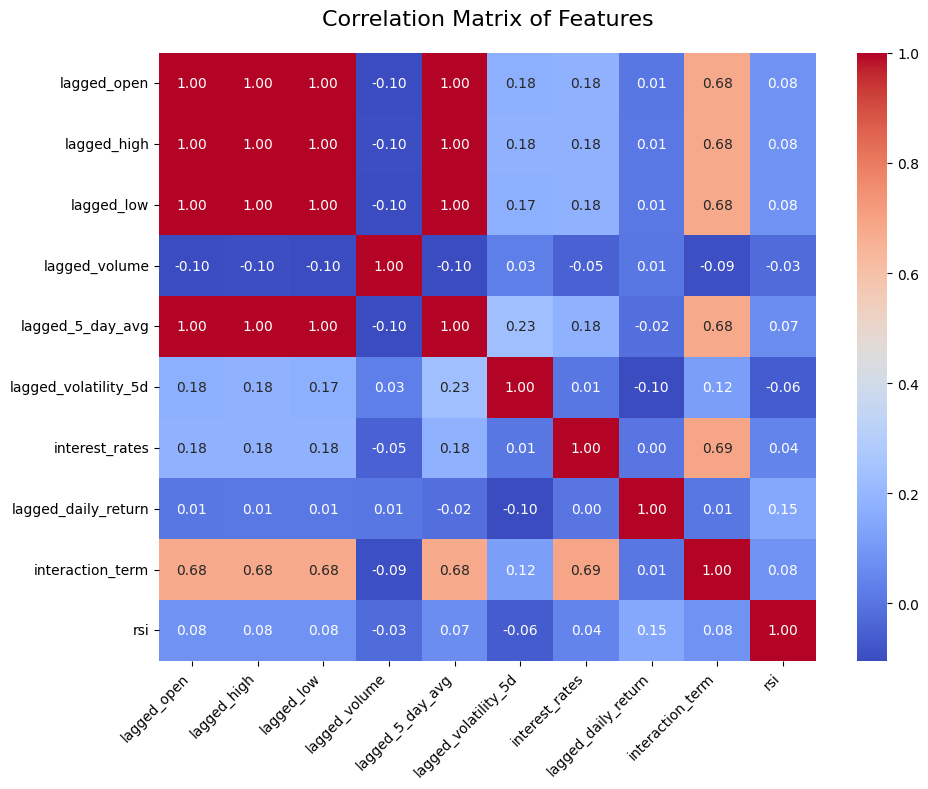

In [ ]:
# Compute and plot the correlation matrix
correlation_matrix = merged_df[['lagged_open', 'lagged_high', 'lagged_low','lagged_volume', 'lagged_5_day_avg', 'lagged_volatility_5d', 'interest_rates', 'lagged_daily_return', 'interaction_term', 'rsi']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**Key Takeaway:** The correlation matrix shown reveals that some variables (lagged_open, lagged_high, lagged_low, lagged_5_day_avg) are highly correlated, with correlations of 1. This indicates significant redundancy among these features as we had also determined in part 5.3.1. High correlation implies multicollinearity, which can negatively impact model performance and interpretability, especially for linear models like regression (we demonstrate this in a later part). To address this we will ensure that we do not include all of these features in our feature set.



### Part 5.2.3: Variance Inflation Factor

To hone in on which features to remove from our feature set we performed VIF. The Variance Inflation Factor (VIF) is a statistical measure used to detect multicollinearity among independent variables in a dataset. It quantifies how much the variance of a regression coefficient is inflated due to collinearity with other predictors.

**Thresholds for VIF:**

VIF = 1: No correlation with other variables

1 < VIF < 5: Moderate correlation, generally acceptable

VIF > 10: High multicollinearity, removal or correction is recommended

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Step 1: Define the independent features
features = ['lagged_open', 'lagged_high', 'lagged_low', 'lagged_volume', 'lagged_5_day_avg', 'lagged_volatility_5d', 'interest_rates', 'lagged_daily_return', 'interaction_term', 'rsi']
X = merged_df[features]  # Replace 'features' with your feature set

# Step 2: Drop any columns that might cause errors (e.g., non-numeric)
X_numeric = X.select_dtypes(include=[float, int])  # Keep only numeric columns

# Step 3: Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Step 4: Display the results
print(vif_data)

                Feature           VIF
0           lagged_open  18887.164565
1           lagged_high  12736.959187
2            lagged_low  11235.323096
3         lagged_volume      1.853131
4      lagged_5_day_avg   1687.566001
5  lagged_volatility_5d      2.998977
6        interest_rates      4.229186
7   lagged_daily_return      1.278875
8      interaction_term      5.303813
9                   rsi      4.981862


From this VIF analysis it is clear that we should remove the variables `lagged_open`, `lagged_low`, `lagged_high`, and `lagged_5_day_avg`. These features have a VIF in the thousands. Although we usually keep one of these correlated features in the feature set, doing this would create an unstable and overfitted model.

Intuitively, these results make sense as a stock's open, low, high, and close price are all usually very similar to each other day to day. Thus, we can remove these features without raising concerns as we have incorporated other features that depend on `lagged_close`.

## Part 5.3: One-hot encoding of stock names

Stock tickers represent categorical data, which machine learning models cannot process directly. To address this, we one-hot encode the stock symbols into binary variables, ensuring that:

**Numerical Representation:** Categorical stock identifiers are transformed into numerical values suitable for modeling.

**Model Flexibility:** One-hot encoding prevents introducing arbitrary ordinal relationships between stock symbols, ensuring fair treatment across all stocks.

**Feature Integration:** The encoded stock identifiers are combined with other numerical features, allowing the model to learn stock-specific patterns.

This step enhances the dataset’s usability while preserving the unique characteristics of each stock for prediction.

In [ ]:
# Encode the stock names (Symbols) into numeric values
merged_df['Symbol'] = merged_df['Name'].astype('category').cat.codes

# One-hot encode Symbol (stock identifier) for embeddings
encoder = OneHotEncoder(sparse_output=False)
symbol_encoded = encoder.fit_transform(merged_df[['Symbol']])

symbol_encoded_df = pd.DataFrame(
   symbol_encoded,
   index=merged_df.index,
   columns=encoder.get_feature_names_out(['Symbol'])
)

# Combine original features with one-hot encoded Symbols
merged_df_features_combined = pd.concat([merged_df, symbol_encoded_df], axis=1)

# features engineered in prior part without all of the highly correlated features
base_features = [
   'lagged_volume',
    'lagged_volatility_5d',
   'interest_rates', 'lagged_daily_return', 'interaction_term', 'rsi'
]

# Identify all Symbol columns (one-hot encoded)
symbol_features = [col for col in merged_df_features_combined.columns if col.startswith('Symbol_')]

# Final feature set
features = base_features + symbol_features
target = 'close'

merged_df_features_combined.head()

,date,open,high,low,close,volume,Name,interest_rates,lagged_close,lagged_5_day_avg,...,Symbol_40,Symbol_41,Symbol_42,Symbol_43,Symbol_44,Symbol_45,Symbol_46,Symbol_47,Symbol_48,Symbol_49
18,2013-03-07,14.70,14.93,14.50,14.82,9125300,AAL,0.16,14.57,13.912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,2013-03-08,14.99,15.20,14.84,14.92,10593700,AAL,0.15,14.82,14.190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2013-03-11,14.85,15.15,14.71,15.13,6961800,AAL,0.16,14.92,14.452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2013-03-12,15.14,15.60,14.95,15.50,8999100,AAL,0.15,15.13,14.698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2013-03-13,15.54,16.20,15.48,15.91,11380000,AAL,0.14,15.50,14.988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Part 5.4: Train-test-split, scaling features, and applying PCA
To further address the issue of multicollinearity, we will apply PCA (Principal Component Analysis). PCA is a dimensionality reduction technique used to simplify datasets while preserving as much variance as possible. PCA will create a smaller set of lower correlated components (principal components). This will eliminate multicollinearity and improve computational efficiency while retaining the key information from these features.

Note: PCA does decrease the interpretability of our model. However, from the above analyses we have determined that the features with the largest impact on close price are lagged_open, lagged_high, and lagged_low. Thus, we will continue with PCA to increase the quality of our model.

### Part 5.4.1: Train-test-split and scaling features
Before applying PCA we will split our data into training and testing data, and we decided to employ a 80 / 20 train-test-split. This is a highly conventional split ratio, and was used in homeworks. However instead of implementing this with a random state, we want to ensure we uphold time-series integrity. Thus, we will group our data by stocks and then by data and then perform an 80/20 split of data for each stock. We will add the split of each stock to two arrays `train_data` and `test_data`.

We will then subset these two arrays to create our X_train, X_test, y_train, and y_test data. For our features for the X data we use the features set we created in an earlier part. For our target variable for our y data we created shifted_close column so that we can predict the next day's closing price.

Also before applying PCA, we will standardize our test and train data. It is crucial to standardize the data using StandardScaler to ensure that all features contribute equally to the analysis. PCA works by identifying directions (principal components) that maximize the variance in the dataset. If features are on different scales (e.g., stock prices in hundreds vs. volatility in percentages), features with larger magnitudes will dominate the variance, skewing the principal components.

We perform these actions in the below code block.

In [ ]:
# Subset the dataset

train_data = []
test_data = []

for symbol, group in merged_df_features_combined.groupby('Symbol'):
    # Sort each stock group by date
    group = group.sort_values(by='date')

    # Apply shift for target (close price of the next day)
    group['shifted_close'] = group['close'].shift(-1)

    # Remove rows with NaN after shifting
    group = group.dropna(subset=['shifted_close'])

    # Split into training (80%) and testing (20%)
    train_size = int(0.8 * len(group))
    train_data.append(group.iloc[:train_size])
    test_data.append(group.iloc[train_size:])

# Combine back into train/test sets
train_data = pd.concat(train_data, ignore_index=True)
test_data = pd.concat(test_data, ignore_index=True)

# Split into features (X) and target (y)
X_train, y_train = train_data[features], train_data['shifted_close']
X_test, y_test = test_data[features], test_data['shifted_close']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Part 5.4.2: Applying PCA

In [ ]:
# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
X_train_scaled_fit = pca.fit(X_train_scaled)

# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)

This plot demonstrates the **cumulative explained variance as a function of the number of principal components** used in Principal Component Analysis (PCA). The x-axis represents the number of components, and the y-axis shows the cumulative explained variance. The goal is to identify the number of components required to capture a significant portion of the variance in the dataset. A horizontal red line at 0.8 (or 80%) indicates a threshold commonly used to retain enough components to preserve the majority of the variance while reducing dimensionality.

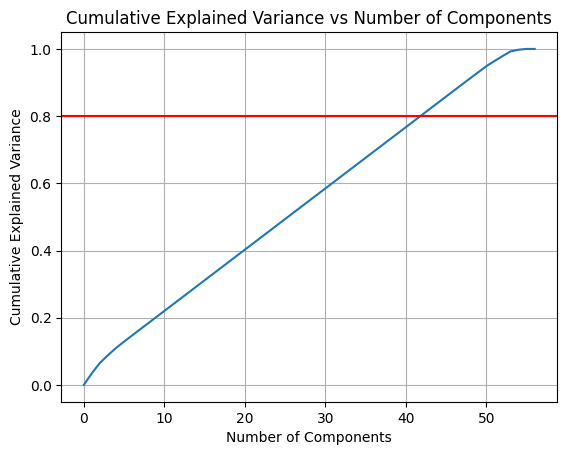

In [ ]:
# Plotting the explained variance vs number of components plot
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1, 10))
plt.grid()
plt.show()

From this plot it is evident that the optimal number of components is 41. We will use this to create our final PCA object which we will apply to our train and test data. After this we will have our finalized train and test data labeled `X_train_pca` and `X_test_pca`.

In [ ]:
# Apply PCA with the specified number of components
pca_final = PCA(n_components=41)  # Keep 41 principal components
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

# Create a DataFrame for the PCA-transformed training data with appropriate column names
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'pca_component_{i+1}' for i in range(X_train_pca.shape[1])])
new_feature_set = X_train_pca_df.columns  # Extract the column names for the new feature set

# Print the shapes of the training and testing sets after PCA
print(f"X_train_pca shape: {X_train_pca.shape}, y_train shape: {y_train.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}, y_test shape: {y_test.shape}")

# Handle missing values in the test set
# Create a mask to filter out rows with NaN values in X_test_pca or y_test
mask = ~np.isnan(X_test_pca).any(axis=1) & ~np.isnan(y_test)

# Apply the mask to remove rows with NaN values from X_test_pca and y_test
X_test_pca = X_test_pca[mask]
y_test = y_test[mask]

X_train_pca shape: (48645, 41), y_train shape: (48645,)
X_test_pca shape: (12185, 41), y_test shape: (12185,)


### General Pipeline Explanation For Our Modeling in the next part
*  Modeling: Linear models, ensemble methods, and boosting models.
*  Evaluation: Used MSE, MAE, and R² to assess performance.

Algorithms:

*   Linear Regression: Baseline with interpretability.
*   Ridge Regression: Added regularization to linear regression.
*   Bootstrapped Linear Regression: Assessed variability and robustness.
*   Random Forest: Modeled non-linear relationships and interactions.
*   XGBoost: Advanced boosting algorithm for optimizing predictive power.



# Part 6: Baseline Models

In this part we experimented with a variety of baseline models to see if any of them captured our data the best. The results are included below. We used the following metrics to evaluate our performance:

**Mean Squared Error:** measures the average squared differences between the predicted and actual values.

**Mean Absolute Error:** Measures the average magnitude of the error without considering direction.

**R² Score (Test):** This indicates how well the model explains the variance in the data.

**R² Score (Train):** measures how the model performs much better on the training data.

## Part 6.1: Regular Linear Regression

**Justification:**

**Why Used:** A simple, interpretable baseline model. Linear regression is ideal for understanding the relationships between features and target variables and provides direct insights through coefficients.

**Limitations:** Assumes linear relationships, sensitivity to multicollinearity, and prone to overfitting with high-dimensional data.

**Mitigation:** Ridge regression was introduced to address multicollinearity and regularization.

There are no hyperparameters to tune in Regular Linear Regression.

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_pca, y_train)

# Predictions
lr_pred = lr_model.predict(X_test_pca)
lr_pred2 = lr_model.predict(X_train_pca)


# Metrics
lr_mse = mean_squared_error(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
r2_train = r2_score(y_train, lr_pred2)

print("Linear Regression Performance:")
print(f"Mean Squared Error: {lr_mse:.2f}")
print(f"Mean Absolute Error: {lr_mae:.2f}")
print(f"R² Score Test: {lr_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")
coefficients = lr_model.coef_

print("Actual values:", y_test[:5].values)
print("Predicted values:", lr_pred[:5])

Linear Regression Performance:
Mean Squared Error: 1403.77
Mean Absolute Error: 31.84
R² Score Test: 0.18
R² Score Train: 0.79
Actual values: [46.57 47.54 46.97 46.91 46.81]
Predicted values: [55.90838004 57.12409968 55.2372237  56.76334852 56.38340477]


**Performance Evaluation:**

The high MSE and low R² test value indicate that this model performs poorly. The test R² of 0.18 suggests the model explains only 18% of the variability in the stock prices, indicating underfitting. With a train R² of 0.79, the model performs much better on the training data. This discrepancy hints at potential overfitting. From the depicted actual and predicted values above we can get a sense of how these values differ.

We plotted the actual vs predicted stock prices below where point represents a stock data instance, with the actual close price (true value) on the x-axis and the predicted close price on the y-axis. Ideally, if the model's predictions were perfect, all points would lie exactly on the red diagonal line (actual price = predicted price).


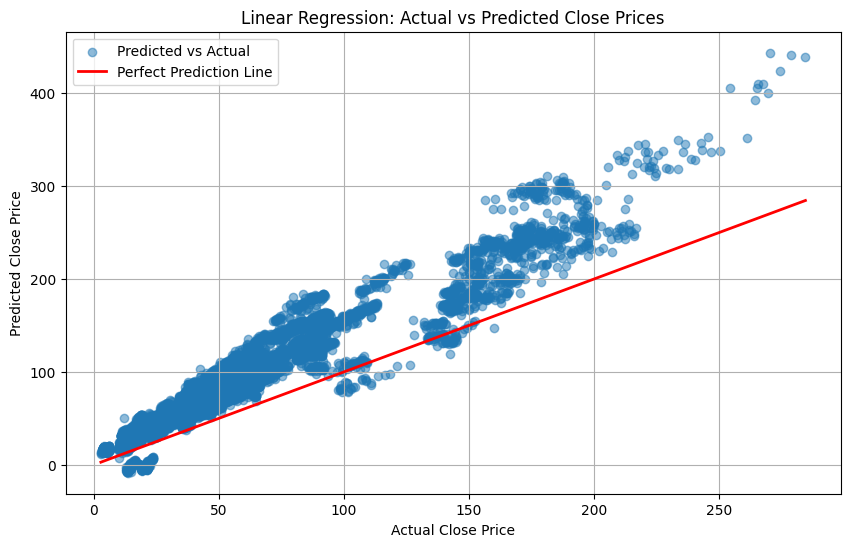

In [ ]:
# Scatter plot for actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Perfect Prediction Line')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Linear Regression: Actual vs Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaways:**

The points closely follow the red line in some ranges (lower prices), indicating better model performance for lower close prices.
However, for higher actual prices (e.g., above ~100), there’s a significant spread. This indicates that the model struggles to predict accurately for higher price values. The scatter of points shows some clustering, which could be due to non-linear patterns in the data that the linear regression model cannot capture.

## Part 6.2: Ridge Regression

We attempted mitigating the issues mentioned above with a second baseline model using a ridge regression.

**Why Used:** Regularized linear regression helps to mitigate overfitting by adding a penalty for large coefficients, improving performance when features are correlated.

**Limitations:** While it reduces overfitting, it does not inherently capture non-linear relationships.

In [ ]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_pca, y_train)

# Predictions
ridge_pred = ridge_model.predict(X_test_pca)
ridge_pred2 = lr_model.predict(X_train_pca)

# Metrics
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
r2_train = r2_score(y_train, ridge_pred2)

print(f"Ridge Regression Performance:")
print(f"Mean Squared Error: {ridge_mse:.2f}")
print(f"Mean Absolute Error: {ridge_mae:.2f}")
print(f"R² Score: {ridge_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")

coefficients = ridge_model.coef_

Ridge Regression Performance:
Mean Squared Error: 1403.72
Mean Absolute Error: 31.83
R² Score: 0.18
R² Score Train: 0.79


**Performance Evaluation:** The Ridge Model has almost identical performance to the Linear Regression Model. The identical metrics indicate that Ridge Regression does not provide any additional benefit over Linear Regression in this scenario. This suggests that non-linear models (e.g., Random Forest, XGBoost) are better suited for this task as they can handle complex relationships in the data.

## Part 6.3: Bootstrapped Linear Regression

After the ridge model we wanted to gain insight on the stability of our linear models.

**Why Used:** Bootstrapping allows us to better understand the variability and stability of the model predictions. By resampling the data, bootstrapping helps address the limitations of relying on a single sample in traditional linear regression.

**Limitations:** Computationally intensive, particularly with large datasets and numerous bootstrap iterations. Does not inherently improve model predictive power because the method focuses on evaluating the model's robustness rather than optimizing its performance.

Bootstrapped linear regression does not have hyperparameters to tune.

In [ ]:
# Parameters for bootstrapping
n_bootstraps = 1000
n_samples = len(X_train_pca)

# Store results
bootstrap_coefficients = []
bootstrap_metrics = []

# Bootstrapping
for _ in range(n_bootstraps):
    # Resample the training data with replacement
    bootstrap_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    X_bootstrap = X_train_pca[bootstrap_indices]
    y_bootstrap = y_train[bootstrap_indices]

    # Fit linear regression on bootstrap sample
    lr_model = LinearRegression()
    lr_model.fit(X_bootstrap, y_bootstrap)

    # Store coefficients
    bootstrap_coefficients.append(lr_model.coef_)

    # Evaluate model on test data
    lr_pred = lr_model.predict(X_test_pca)
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_mae = mean_absolute_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)

    bootstrap_metrics.append([lr_mse, lr_mae, lr_r2])

# Convert results to arrays for analysis
bootstrap_coefficients = np.array(bootstrap_coefficients)
bootstrap_metrics = np.array(bootstrap_metrics)

# Analyze Metrics
metrics_mean = np.mean(bootstrap_metrics, axis=0)
metrics_std = np.std(bootstrap_metrics, axis=0)

print("\nBootstrap Metrics (Mean ± Std):")
print(f"Mean Squared Error: {metrics_mean[0]:.2f} ± {metrics_std[0]:.2f}")
print(f"Mean Absolute Error: {metrics_mean[1]:.2f} ± {metrics_std[1]:.2f}")
print(f"R² Score: {metrics_mean[2]:.2f} ± {metrics_std[2]:.2f}")


Bootstrap Metrics (Mean ± Std):
Mean Squared Error: 1404.71 ± 29.01
Mean Absolute Error: 31.83 ± 0.38
R² Score: 0.18 ± 0.02


**Performance Evaluation:** The low variability in metrics across bootstrap samples indicates that the model's performance is stable and not overly sensitive to specific training samples. The consistently low R² score highlight again the limitations of linear regression for non-linear relationships.

# Part 7: Second Model: Random Forest Regression
**Why Used:** Captures non-linear relationships and handles interactions between features without requiring explicit specification. It is robust to overfitting when tuned properly. Both of these were evident issues with our linear regression model, so this seemed like the best choice to proceed with.

**Limitations:** Lacks interpretability and can overfit without proper hyperparameter tuning.

**Hyperparameters:**

n_estimators: Number of trees.

max_depth: Maximum depth of each tree.

min_samples_split / min_samples_leaf: Minimum samples to split a node / end in a leaf

max_features: Maximum features used for splitting (e.g., 'sqrt' or fraction)

random_state: Controls randomness for reproducibility.

In [ ]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=50,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt", random_state=42)
rf_model.fit(X_train_pca, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_pca)
rf_pred2 = rf_model.predict(X_train_pca)

# Metrics
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
r2_train = r2_score(y_train, rf_pred2)

print("Random Forest Performance:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")

Random Forest Performance:
Mean Squared Error: 852.57
Mean Absolute Error: 16.34
R² Score: 0.50
R² Score Train: 0.85


**Performance Evaluation:** The Random Forest model achieves a test R² score of 0.50, indicating that the model explains 50% of the variance in the target variable on the test set. The Mean Squared Error (MSE) is 852.57, and the Mean Absolute Error (MAE) is 16.34, suggesting that the average prediction error is approximately 16 units from the true values.

Interestingly, the training R² score of 0.85 indicates that the model performs significantly better on the training set, which may hint at mild overfitting. While the model captures the overall trends in the data, there is room for improvement through hyperparameter tuning or additional feature engineering.

Below we plot the learning curve for the testing error and training error.

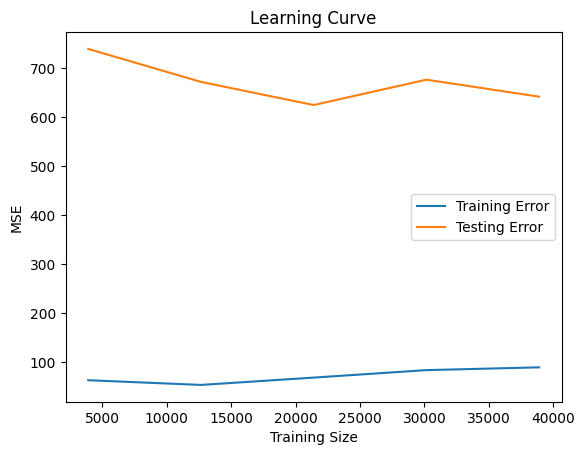

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train_pca, y_train, cv=5, scoring="neg_mean_squared_error"
)

plt.plot(train_sizes, -train_scores.mean(axis=1), label="Training Error")
plt.plot(train_sizes, -test_scores.mean(axis=1), label="Testing Error")
plt.xlabel("Training Size")
plt.ylabel("MSE")
plt.legend()
plt.title("Learning Curve")
plt.show()

This diagram suggests we need to hypertune our model as our training data seems to be overfitting. Since the training error and testing error lines do not converge it confirms this.

To perform hypertuning we attempted to use GridSearchCV, but it required a large runtime. Thus we decided to implement RandomizedSearchCV. RandomizedSearch samples a subset of the parameter space, making it faster than trying all combinations in GridSearchCV. We implement this below. Note: this took around 9 minutes to run.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20, 30, 40],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,                    # Number of parameter settings sampled
    cv=5,                         # Number of cross-validation folds
    verbose=2,                    # Display output during fitting
    random_state=42,
    n_jobs=-1                     # Use all available cores
)

# Fit RandomizedSearchCV on the training data
random_search.fit(X_train_pca, y_train)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}
Best CV Score: -0.15637338334339146


We will now create a new RandomForestRegressor with these parameters.

In [ ]:
# Instantiate a new RandomForestRegressor with the parameters determined ideal via RandomizedSerachCV
rf_best = RandomForestRegressor(n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="log2", random_state=42)
rf_best.fit(X_train_pca, y_train)

# Predictions
rf_pred = rf_best.predict(X_test_pca)
rf_pred2 = rf_best.predict(X_train_pca)

# Metrics
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
r2_train = r2_score(y_train, rf_pred2)

print("Random Forest Performance:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"Mean Absolute Error: {rf_mae:.2f}")
print(f"R² Score: {rf_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")

Random Forest Performance:
Mean Squared Error: 371.48
Mean Absolute Error: 9.44
R² Score: 0.78
R² Score Train: 0.98


This performance indicates that the hyperparameter tuning process was effective in balancing model complexity and generalization. However, with an R² value of nearly one this model is likely prone to overfitting which could be a future issue we will need to address.

The below plot evaluates the accuracy of the Random Forest model.

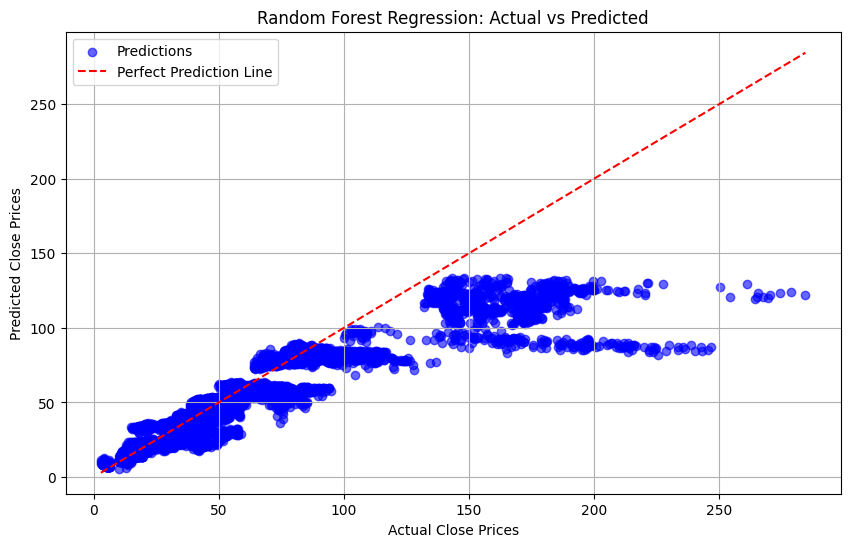

In [ ]:
# Scatter plot for Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.6, color='b', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Prediction Line')
plt.title('Random Forest Regression: Actual vs Predicted')
plt.xlabel('Actual Close Prices')
plt.ylabel('Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaways:** The model performs well overall. The presence of minor deviations at higher prices suggests potential areas for improvement, such as handling outliers or refining features related to high-price stocks. This reinforces the model's strong but slightly imperfect predictive capability.

# Part 8: Third Model: XGBoost Regression
**Why Used:** A highly efficient, scalable gradient boosting algorithm that can capture complex patterns and interactions while controlling for overfitting using regularization parameters.

**Limitations:** Requires careful hyperparameter tuning and is less interpretable than simpler models.

**Hyperparameters:**

n_estimators: Number of boosting rounds (trees)

max_depth: Maximum depth of trees

learning_rate: Step size for each tree’s contribution

subsample / colsample_bytree: Fraction of data sampled per tree

Regularization: lambda (L2) and alpha (L1) to prevent overfitting

random_state: Ensures reproducibility.

In [ ]:
# XGBoost Regression
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.05, max_depth=5, random_state=42, reg_alpha=0.5, reg_lambda=1, subsample=0.8,colsample_bytree=0.8)
xgb_model.fit(X_train_pca, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test_pca)
xgb_pred2 = xgb_model.predict(X_train_pca)

# Metrics
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
r2_train = r2_score(y_train, xgb_pred2)

print("XGBoost Performance:")
print(f"Mean Squared Error: {xgb_mse:.2f}")
print(f"Mean Absolute Error: {xgb_mae:.2f}")
print(f"R² Score: {xgb_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")

XGBoost Performance:
Mean Squared Error: 442.26
Mean Absolute Error: 11.56
R² Score: 0.74
R² Score Train: 0.92


**Performance Evaluation:** The model achieves a test R² score of 0.74, indicating that the model explains 74% of the variance in the target variable on the test set. The Mean Squared Error (MSE) is 442.26, and the Mean Absolute Error (MAE) is 11.56, suggesting that the average prediction error is approximately 16 units from the true values.

The training R² score of 0.92 again indicates that the model performs significantly better on the training set, which is a sign of overfitting. While the model captures the overall trends in the data, this shows there is a need for tuning hyperparameters or engineering more features.

Similar to the Random Forest model we performed RandomizedSearchCV on the XGBoost Model to tune our hyperparameters:

In [ ]:
# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid to search
param_dist = {
    "n_estimators": [50, 100, 200, 300, 400],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1],
    "reg_lambda": [0.1, 0.5, 1, 2, 5],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=10,  # Number of random configurations to try
    cv=5,       # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1,  # Use all processors
)

# Fit the randomized search on training data
random_search.fit(X_train_pca, y_train)

# Get the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best CV Score (RMSE):", np.sqrt(-random_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best CV Score (RMSE): 17.02601856444885


We will now create a new XGBRegressor with these parameters.

In [ ]:
# XGBoost Regression
xgb_best = XGBRegressor(n_estimators=400, learning_rate=0.2, max_depth=7, random_state=42, reg_alpha=0.01, reg_lambda=2, subsample=0.8,colsample_bytree=0.9)
xgb_best.fit(X_train_pca, y_train)

# Predictions
xgb_pred = xgb_best.predict(X_test_pca)
xgb_pred2 = xgb_best.predict(X_train_pca)

# Metrics
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
r2_train = r2_score(y_train, xgb_pred2)

print("XGBoost Performance:")
print(f"Mean Squared Error: {xgb_mse:.2f}")
print(f"Mean Absolute Error: {xgb_mae:.2f}")
print(f"R² Score: {xgb_r2:.2f}")
print(f"R² Score Train: {r2_train:.2f}")

XGBoost Performance:
Mean Squared Error: 232.06
Mean Absolute Error: 7.82
R² Score: 0.86
R² Score Train: 0.99


The tuned XGBoost model performs better. The high R² score on the test set suggests a well-fit model and the difference between the test R² and train R² has decreased. The improvement in error metrics further underscores its enhanced predictive capability.

The below diagram plots the accuracy of this model.

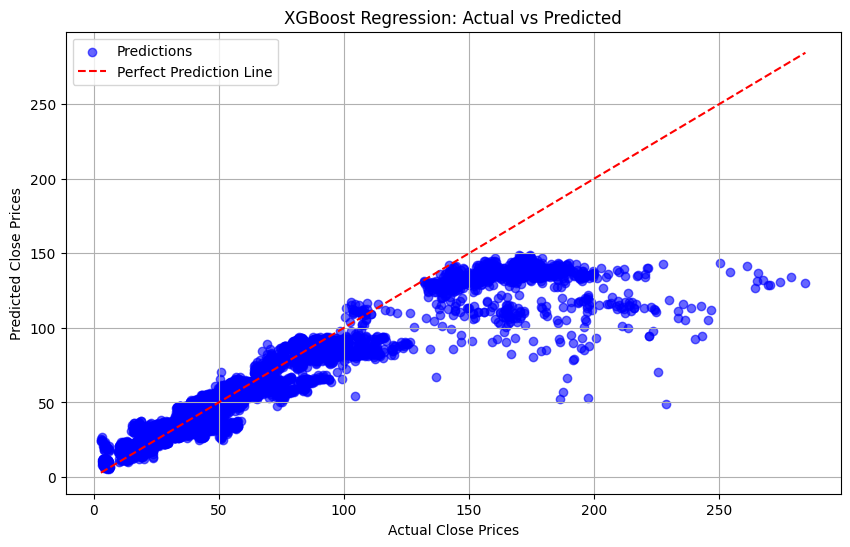

In [ ]:
# Scatter plot for Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred, alpha=0.6, color='b', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Perfect Prediction Line')
plt.title('XGBoost Regression: Actual vs Predicted')
plt.xlabel('Actual Close Prices')
plt.ylabel('Predicted Close Prices')
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaways:**

There are slight deviations at higher price ranges suggest that the model struggles marginally with extreme values, which could be due to data sparsity or outliers in the higher range. Other than that the tuned XGBoost model performs well.

### Results: Model Performance and Comparison

The performance of the models varied significantly, highlighting the strengths and limitations of each approach:

1. **Linear Regression**:
   - **Performance**: As a baseline model, it performed poorly, achieving a low \( R^2 \) score but relatively high MSE and MAE.
   - **Reasoning**: The model assumes linear relationships between features and the target variable, which limits its ability to capture complex interactions and non-linear patterns.

2. **Ridge Regression**:
   - **Performance**: Improved slightly over Linear Regression, with reduced MSE and MAE. The \( R^2 \) score also saw a modest increase, indicating better fit.
   - **Reasoning**: The addition of regularization helped mitigate overfitting, particularly in the presence of multicollinearity among features.

3. **Bootstrapped Linear Regression**:
   - **Performance**: Provided robust estimates with variability metrics for coefficients and predictions. While the mean performance metrics (MSE, MAE, \( R^2 \)) were comparable to Linear Regression, the standard deviations highlighted the model's stability.
   - **Reasoning**: Bootstrapping did not inherently improve prediction accuracy but offered valuable insights into model reliability and the robustness of coefficient estimates.

4. **Random Forest Regression**:
   - **Performance**: Outperformed both Linear and Ridge Regression, achieving lower MSE and MAE, and a higher \( R^2 \) score. It captured non-linear relationships effectively.
   - **Reasoning**: The ensemble approach allowed the model to handle interactions and non-linearities in the data, reducing bias and variance when tuned properly.

5. **XGBoost Regression**:
   - **Performance**: Delivered the best overall performance across all metrics, with the lowest MSE and MAE and the highest \( R^2 \) score.
   - **Reasoning**: XGBoost's advanced boosting algorithm leveraged regularization and gradient optimization to capture complex patterns and improve generalization.

### Comparison:
- **Interpretability**: Linear and Ridge Regression provided interpretable results through their coefficients, which are useful for understanding feature importance. However, their simplicity limited predictive power.
- **Predictive Accuracy**: Random Forest and XGBoost significantly outperformed linear models due to their ability to capture non-linear relationships and interactions.
- **Robustness**: The bootstrapped linear regression model provided valuable insights into model stability, emphasizing robustness over raw predictive power.

### Conclusion:
XGBoost emerged as the most effective model for this dataset, demonstrating superior performance in capturing complex relationships while maintaining generalization. However, simpler models like Ridge Regression remain valuable for interpretability and understanding the driving factors behind predictions. Bootstrapping complements these efforts by quantifying model variability. The choice of model ultimately depends on the trade-off between interpretability and predictive performance based on the specific use case.

# Part 9: Conclusion and Key Discussions

## Challenges and Limitations
**Data Limitations:**

The dataset is confined to historical data from 2013–2018, which may not accurately reflect current market dynamics or evolving economic conditions.

**Interpretability vs. Predictive Power:**

While non-linear models, such as XGBoost, offer superior predictive accuracy, they lack the transparency of linear methods, making it difficult for stakeholders to extract actionable insights. Using PCA also limits the Interpretability of the model.

**Enhanced Feature Set:**

Overfitting in our models seemed to be a consistent issue. We struggled to pinpoint where exactly this was occurring from. In the future we would hope to reduce this by removing less relevant features. Also if we could incorporate additional macroeconomic variables, such as inflation rates, GDP growth, or consumer confidence indices, could provide a more detailed understanding of market trends and improve predictive performance.

**Temporal Relationships:**

Adopting time-series models  could better capture sequential dependencies and temporal trends, leading to more accurate and robust predictions for stock price movements.

## Key Insights

**XGBoost Excellence:**

XGBoost demonstrated superior accuracy and generalization, making it ideal for predictive tasks involving complex, non-linear relationships.

**Trade-Off Clarity:**

Simpler models like Ridge Regression offer interpretability and insights into feature importance, valuable for explanatory analysis

**Model Reliability:**

Bootstrapped regression highlighted model stability and coefficient robustness, emphasizing reliability in uncertain datasets.

**Data Interactions:**

Non-linear models (Random Forest, XGBoost) revealed significant interactions and patterns, underscoring the need for advanced techniques in complex datasets.

**Feature Analysis:**

Features such as open, low, and high price were heavily correlated to the close price. Out of the rest of the features we analyzed interaction_term and interest_rates had the next highest correlations. This indicates how large of a role these features played in our models.

## Team Reflection

We learned a lot from building this project from scratch, debugging issues as they arose, and analyzing the models and metrics we evaluated. This was a great process to also learn a lot more about stock predictions (it's not simple to do for a reason!).